In [72]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2
from keras.utils import normalize

In [73]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

In [74]:
path = '/Users/sahilapte/Desktop/datasets/archive/video55'

In [75]:
images = []
masks = []

In [76]:
HEIGHT = 256
WIDTH =256

In [77]:
#imcount = 0
#lcount = 0

In [78]:
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        im = os.path.join(dirname, filename)
        if 'endo.png' in im :
            img = cv2.imread(im, 0)
            img = cv2.resize(img, (HEIGHT,WIDTH))
            img = np.array(img)
            images.append(img)
        elif 'endo_color_mask.png'in im:
            img = cv2.imread(im, 0) 
            img = cv2.resize(img, (HEIGHT,WIDTH), interpolation = cv2.INTER_NEAREST)
            img = np.array(img)
            masks.append(img)

In [79]:
len(images)

240

In [80]:
len(masks)

240

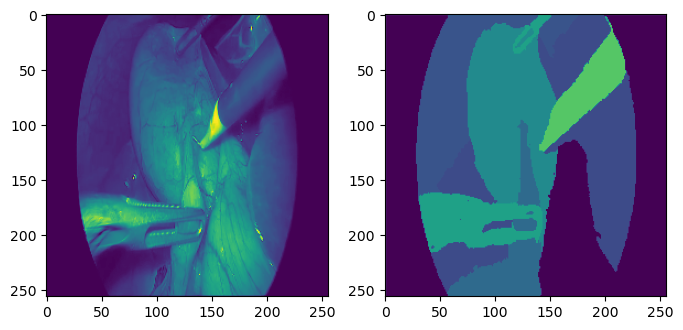

In [81]:
fig, ax = plt.subplots(1,2, figsize = (8,4))
ax[0].imshow(images[0])
ax[1].imshow(masks[0])
plt.show()

In [82]:
images = np.array(images)
masks = np.array(masks)

In [83]:
images.shape

(240, 256, 256)

In [84]:
from sklearn.preprocessing import LabelEncoder

In [85]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = masks.shape
reshaped = masks.reshape(-1,1)
encoded = labelencoder.fit_transform(reshaped)
original_shape = encoded.reshape(n, h, w)

np.unique(original_shape)

array([0, 1, 2, 3, 4, 5, 6, 7])

In [86]:
n_classes = 8

In [87]:
train_images = np.expand_dims(images, axis=3)

In [88]:
train_images = normalize(train_images, axis=1)

In [89]:
train_masks_input = np.expand_dims(original_shape, axis=3)

In [90]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, train_masks_input, test_size = 0.10, random_state = 0)

In [91]:
X_train.shape

(216, 256, 256)

In [92]:
X_test.shape

(24, 256, 256)

In [93]:
from keras.utils import to_categorical

In [94]:
train_masks_cat = to_categorical(y_train, num_classes=n_classes,dtype='float32')
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

In [95]:
test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

In [96]:
#from sklearn.utils import class_weight
#class_weights = class_weight.compute_class_weight(class_weight = "balanced",
                                       # classes = np.unique(encoded),
                                       # y = encoded )

In [97]:
#print("Class weights:", class_weights)

In [98]:
def multi_unet_model(n_classes=8, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):

    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    
    
    return model

In [99]:
model = multi_unet_model()

In [100]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 16  160         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_9 (Dropout)            (None, 256, 256, 16  0           ['conv2d_19[0][0]']              
                                )                                                           

                                                                                                  
 dropout_16 (Dropout)           (None, 128, 128, 32  0           ['conv2d_33[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_34 (Conv2D)             (None, 128, 128, 32  9248        ['dropout_16[0][0]']             
                                )                                                                 
                                                                                                  
 conv2d_transpose_7 (Conv2DTran  (None, 256, 256, 16  2064       ['conv2d_34[0][0]']              
 spose)                         )                                                                 
                                                                                                  
 concatena

In [101]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 16  160         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_9 (Dropout)            (None, 256, 256, 16  0           ['conv2d_19[0][0]']              
                                )                                                           

                                                                                                  
 dropout_16 (Dropout)           (None, 128, 128, 32  0           ['conv2d_33[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_34 (Conv2D)             (None, 128, 128, 32  9248        ['dropout_16[0][0]']             
                                )                                                                 
                                                                                                  
 conv2d_transpose_7 (Conv2DTran  (None, 256, 256, 16  2064       ['conv2d_34[0][0]']              
 spose)                         )                                                                 
                                                                                                  
 concatena

In [102]:
history = model.fit(X_train, y_train_cat, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=200, 
                    validation_data=(X_test, y_test_cat)) 

Epoch 1/200


2022-12-14 10:53:46.822933: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - ETA: 0s - loss: 18.2836 - accuracy: 0.1773

2022-12-14 10:53:52.335870: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 6s 378ms/step - loss: 18.2836 - accuracy: 0.1773 - val_loss: 2.5462 - val_accuracy: 0.2590
Epoch 2/200
14/14 [==============================] - 5s 343ms/step - loss: 3.1253 - accuracy: 0.2471 - val_loss: 1.9171 - val_accuracy: 0.3473
Epoch 3/200
14/14 [==============================] - 5s 335ms/step - loss: 1.8275 - accuracy: 0.3505 - val_loss: 1.6612 - val_accuracy: 0.3851
Epoch 4/200
14/14 [==============================] - 5s 342ms/step - loss: 1.5802 - accuracy: 0.4200 - val_loss: 1.5700 - val_accuracy: 0.4242
Epoch 5/200
14/14 [==============================] - 5s 340ms/step - loss: 1.5314 - accuracy: 0.4315 - val_loss: 1.5170 - val_accuracy: 0.4288
Epoch 6/200
14/14 [==============================] - 5s 342ms/step - loss: 1.5095 - accuracy: 0.4344 - val_loss: 1.5108 - val_accuracy: 0.4294
Epoch 7/200
14/14 [==============================] - 5s 347ms/step - loss: 1.4970 - accuracy: 0.4360 - val_loss: 1.5026 - val_accuracy: 0.4297
Epoch 8/20

14/14 [==============================] - 5s 353ms/step - loss: 0.7291 - accuracy: 0.7048 - val_loss: 0.8670 - val_accuracy: 0.6738
Epoch 59/200
14/14 [==============================] - 5s 360ms/step - loss: 0.7259 - accuracy: 0.7059 - val_loss: 0.8131 - val_accuracy: 0.6950
Epoch 60/200
14/14 [==============================] - 5s 351ms/step - loss: 0.7148 - accuracy: 0.7112 - val_loss: 0.7820 - val_accuracy: 0.6964
Epoch 61/200
14/14 [==============================] - 5s 352ms/step - loss: 0.6962 - accuracy: 0.7204 - val_loss: 0.8534 - val_accuracy: 0.6768
Epoch 62/200
14/14 [==============================] - 5s 353ms/step - loss: 0.6858 - accuracy: 0.7232 - val_loss: 0.8231 - val_accuracy: 0.6784
Epoch 63/200
14/14 [==============================] - 5s 341ms/step - loss: 0.6626 - accuracy: 0.7301 - val_loss: 0.7607 - val_accuracy: 0.7106
Epoch 64/200
14/14 [==============================] - 5s 350ms/step - loss: 0.6577 - accuracy: 0.7342 - val_loss: 0.7611 - val_accuracy: 0.7403
Epoch

Epoch 115/200
14/14 [==============================] - 5s 369ms/step - loss: 0.3948 - accuracy: 0.8482 - val_loss: 0.5482 - val_accuracy: 0.8084
Epoch 116/200
14/14 [==============================] - 5s 366ms/step - loss: 0.3975 - accuracy: 0.8492 - val_loss: 0.5311 - val_accuracy: 0.7992
Epoch 117/200
14/14 [==============================] - 5s 370ms/step - loss: 0.3917 - accuracy: 0.8522 - val_loss: 0.5507 - val_accuracy: 0.8068
Epoch 118/200
14/14 [==============================] - 5s 368ms/step - loss: 0.3842 - accuracy: 0.8512 - val_loss: 0.5290 - val_accuracy: 0.8060
Epoch 119/200
14/14 [==============================] - 5s 370ms/step - loss: 0.3870 - accuracy: 0.8514 - val_loss: 0.5396 - val_accuracy: 0.8010
Epoch 120/200
14/14 [==============================] - 5s 373ms/step - loss: 0.3779 - accuracy: 0.8554 - val_loss: 0.5381 - val_accuracy: 0.8035
Epoch 121/200
14/14 [==============================] - 5s 374ms/step - loss: 0.3718 - accuracy: 0.8566 - val_loss: 0.5808 - val_ac

14/14 [==============================] - 5s 362ms/step - loss: 0.2940 - accuracy: 0.8840 - val_loss: 0.5412 - val_accuracy: 0.8065
Epoch 172/200
14/14 [==============================] - 5s 361ms/step - loss: 0.2968 - accuracy: 0.8823 - val_loss: 0.5379 - val_accuracy: 0.8003
Epoch 173/200
14/14 [==============================] - 5s 363ms/step - loss: 0.2941 - accuracy: 0.8825 - val_loss: 0.5508 - val_accuracy: 0.8021
Epoch 174/200
14/14 [==============================] - 5s 361ms/step - loss: 0.2918 - accuracy: 0.8871 - val_loss: 0.5528 - val_accuracy: 0.7984
Epoch 175/200
14/14 [==============================] - 5s 369ms/step - loss: 0.3003 - accuracy: 0.8819 - val_loss: 0.5434 - val_accuracy: 0.8045
Epoch 176/200
14/14 [==============================] - 5s 367ms/step - loss: 0.2930 - accuracy: 0.8856 - val_loss: 0.5267 - val_accuracy: 0.8132
Epoch 177/200
14/14 [==============================] - 5s 382ms/step - loss: 0.2925 - accuracy: 0.8850 - val_loss: 0.5358 - val_accuracy: 0.8091

In [103]:
model.save('200ev55.h5')

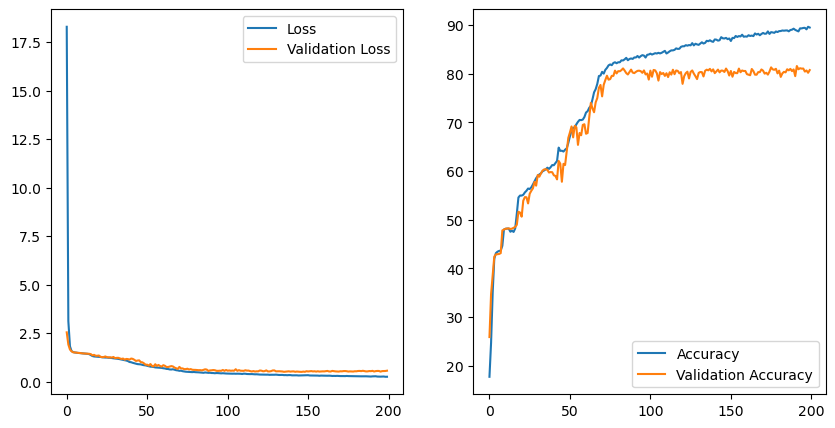

In [104]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(history.history['loss'], '-', label = 'Loss')
ax1.plot(history.history['val_loss'], '-', label = 'Validation Loss')
ax1.legend()

ax2.plot(100*np.array(history.history['accuracy']), '-', 
         label = 'Accuracy')
ax2.plot(100*np.array(history.history['val_accuracy']), '-',
         label = 'Validation Accuracy')
ax2.legend()

In [105]:
#########Prediction

In [106]:
y_test_cat.shape

(24, 256, 256, 8)

In [107]:
from keras.models import Model, load_model
model = load_model('200ev55.h5')
param, acc = model.evaluate(X_test,y_test_cat)
acc

preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(cv2.resize(np.squeeze(preds_test[i]), 
                                       (256, 256)))

2022-12-14 11:10:53.376019: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 393ms/step - loss: 0.5703 - accuracy: 0.8076


2022-12-14 11:10:53.770153: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 136ms/step


In [ ]:
####TESTING

In [108]:
test_img=X_test[0]
test_img

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

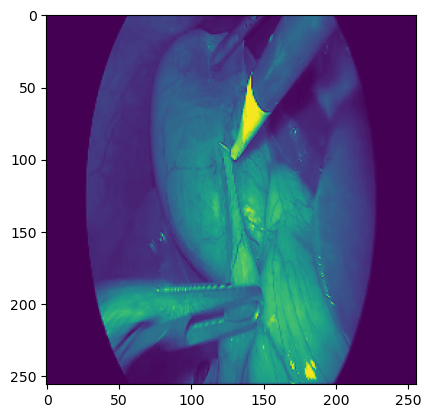

In [109]:
plt.imshow(test_img)

1/1 [==============================] - 0s 186ms/step


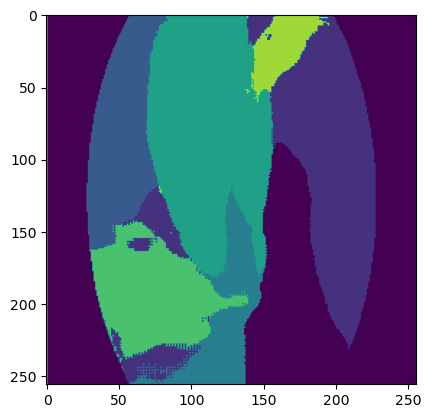

In [110]:
#test_img = X_test[0]
test_img_norm=test_img#[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]
plt.imshow(predicted_img)

1/1 [==============================] - 0s 12ms/step


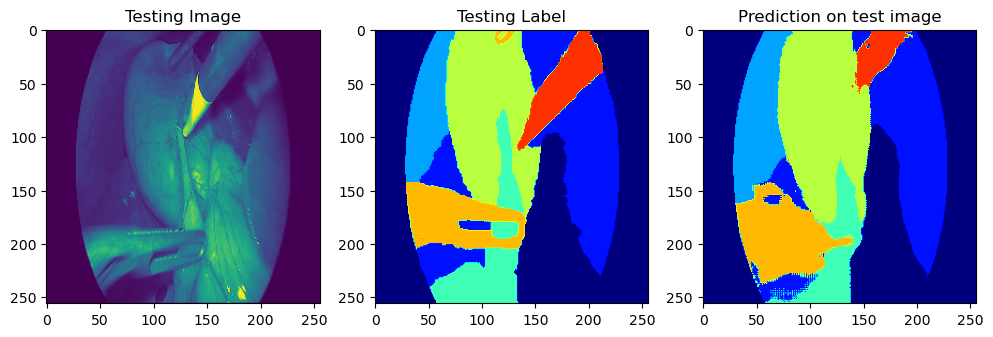

1/1 [==============================] - 0s 12ms/step


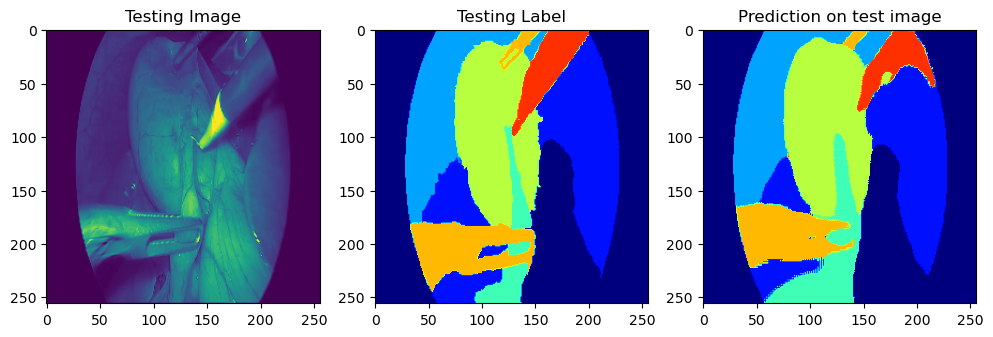

1/1 [==============================] - 0s 11ms/step


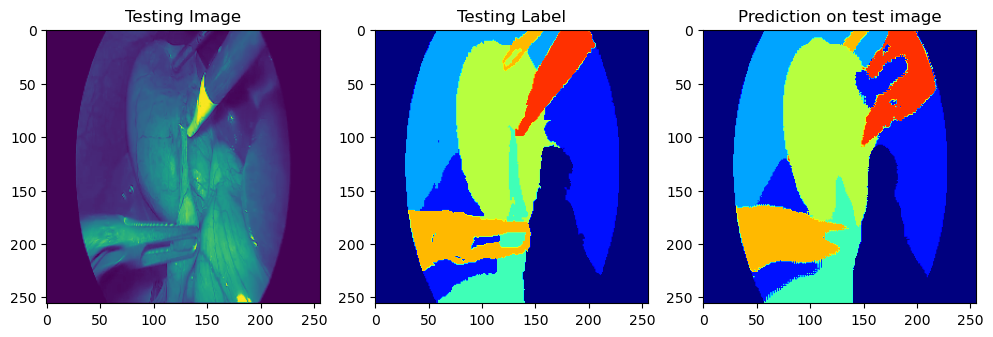

1/1 [==============================] - 0s 15ms/step


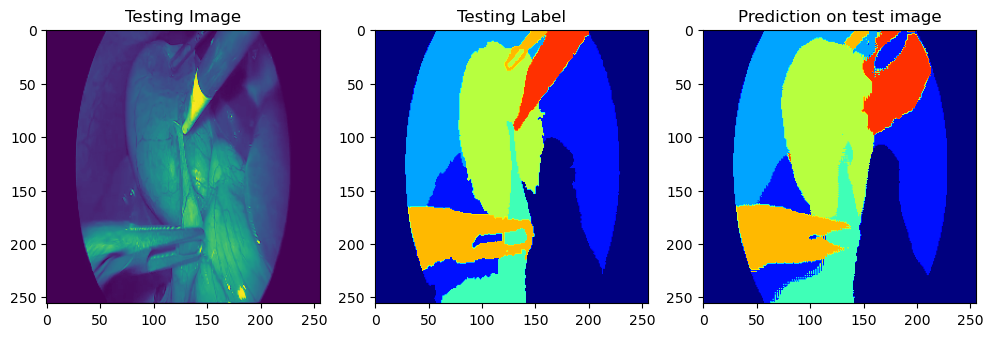

1/1 [==============================] - 0s 25ms/step


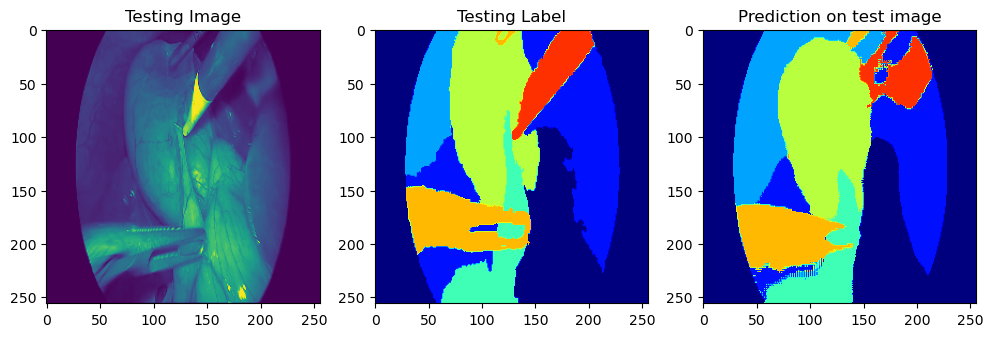

1/1 [==============================] - 0s 11ms/step


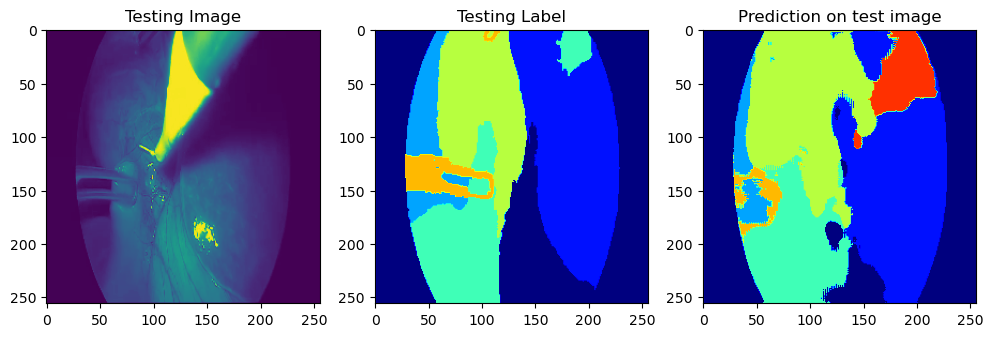

1/1 [==============================] - 0s 11ms/step


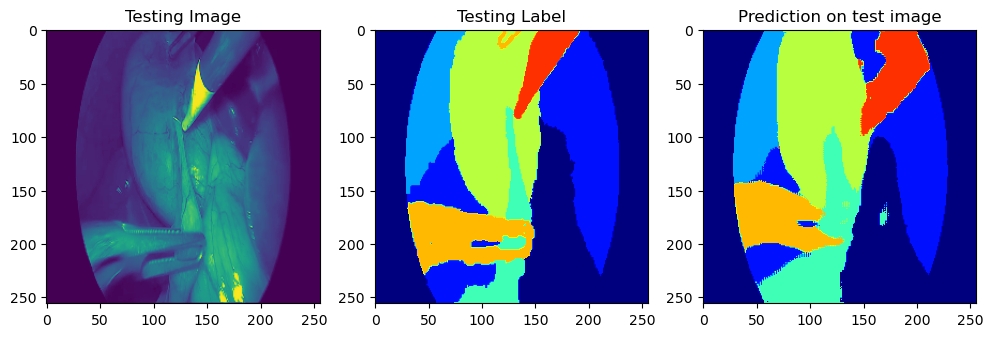

1/1 [==============================] - 0s 27ms/step


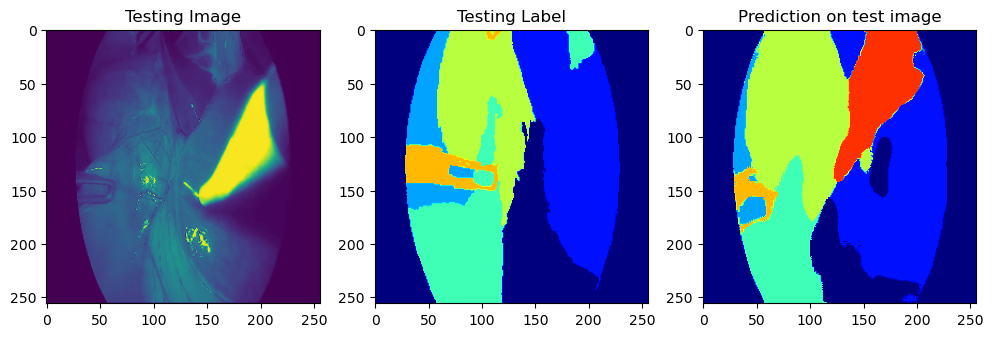

1/1 [==============================] - 0s 10ms/step


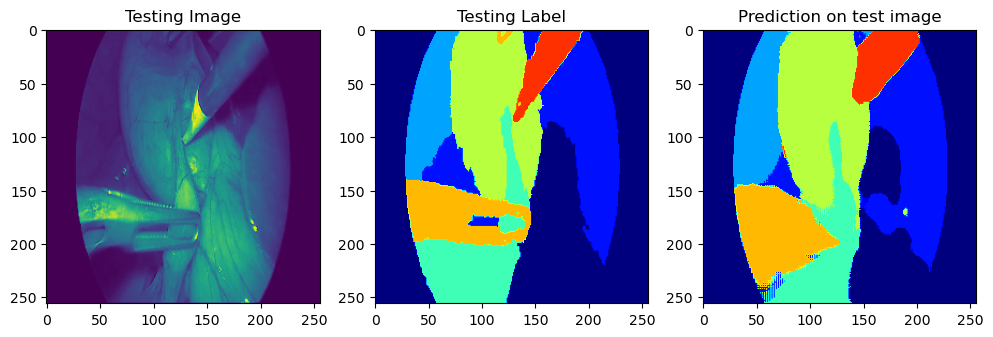

1/1 [==============================] - 0s 11ms/step


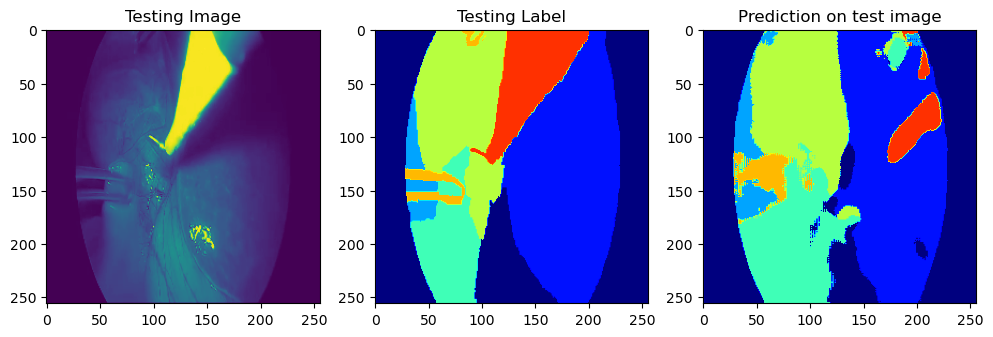

1/1 [==============================] - 0s 10ms/step


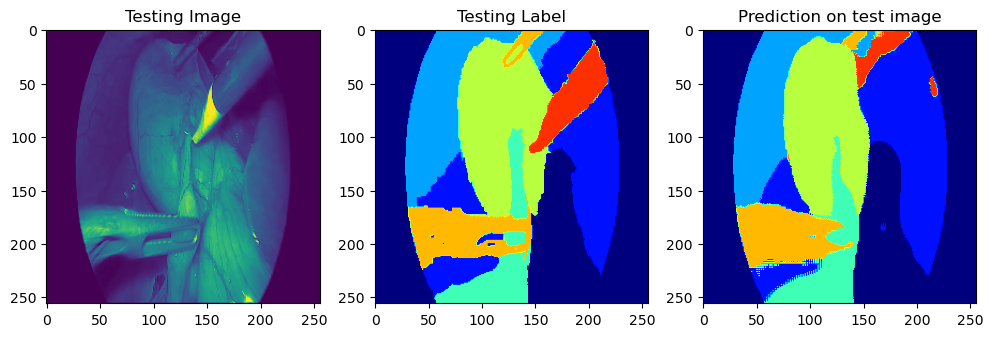

1/1 [==============================] - 0s 11ms/step


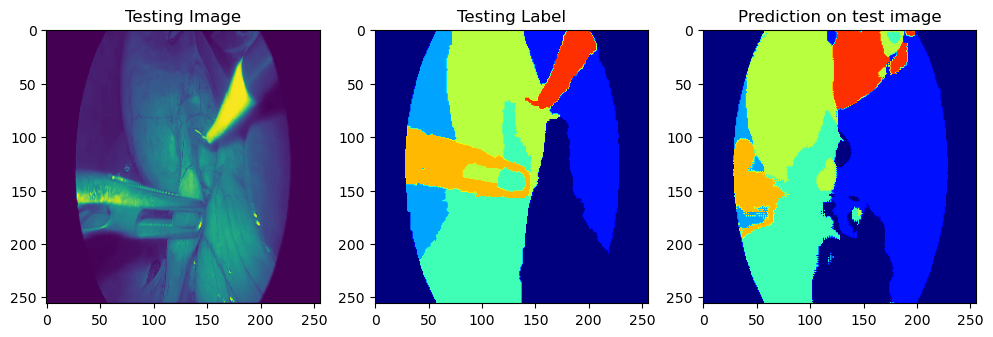

1/1 [==============================] - 0s 10ms/step


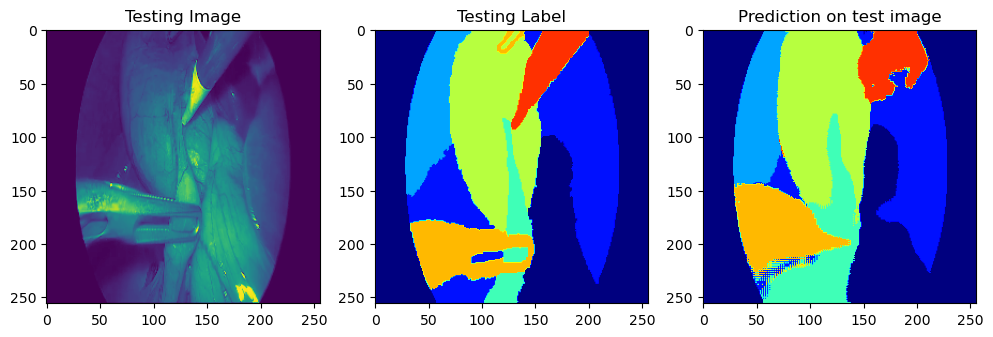

1/1 [==============================] - 0s 11ms/step


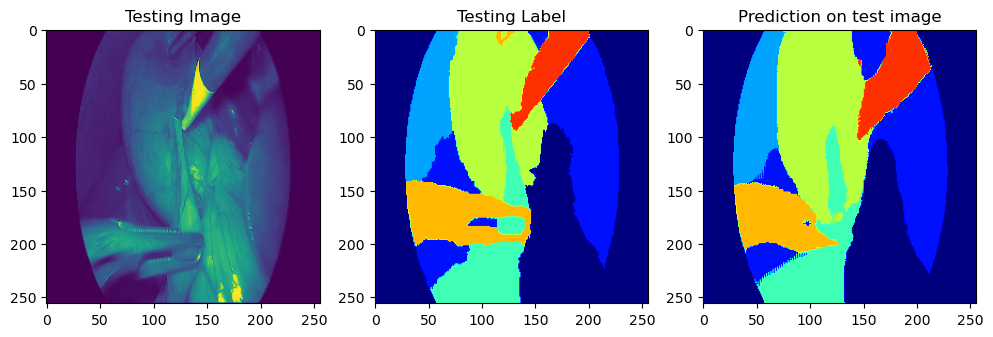

1/1 [==============================] - 0s 11ms/step


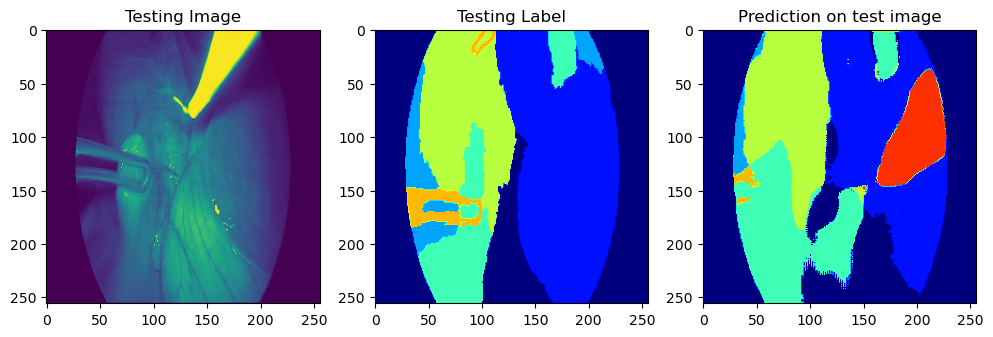

1/1 [==============================] - 0s 14ms/step


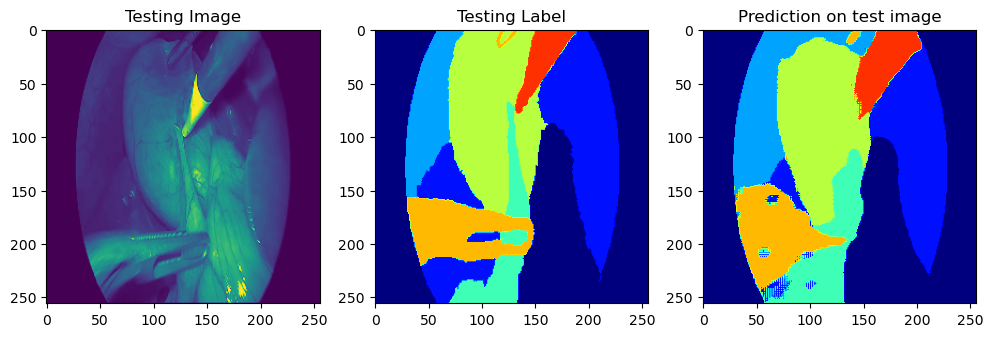

1/1 [==============================] - 0s 13ms/step


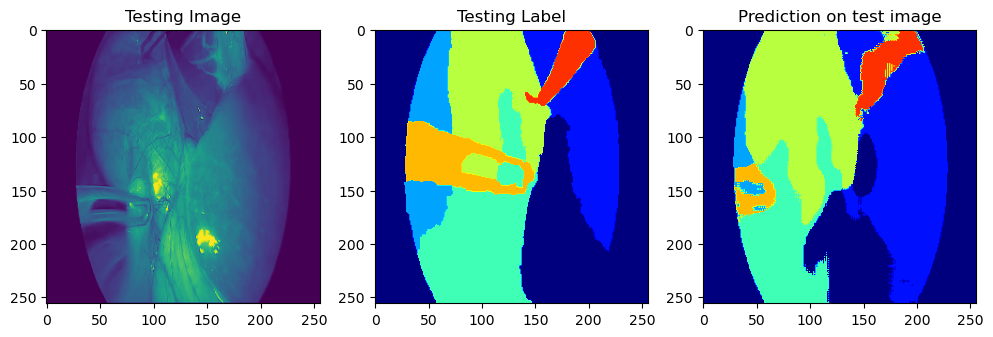

1/1 [==============================] - 0s 10ms/step


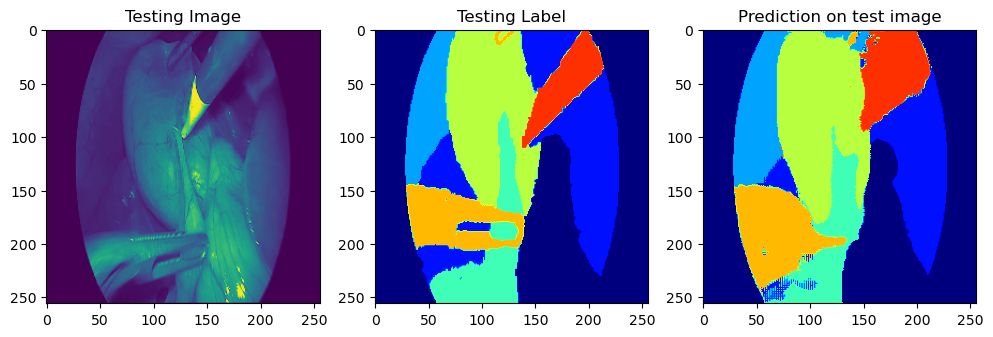

1/1 [==============================] - 0s 10ms/step


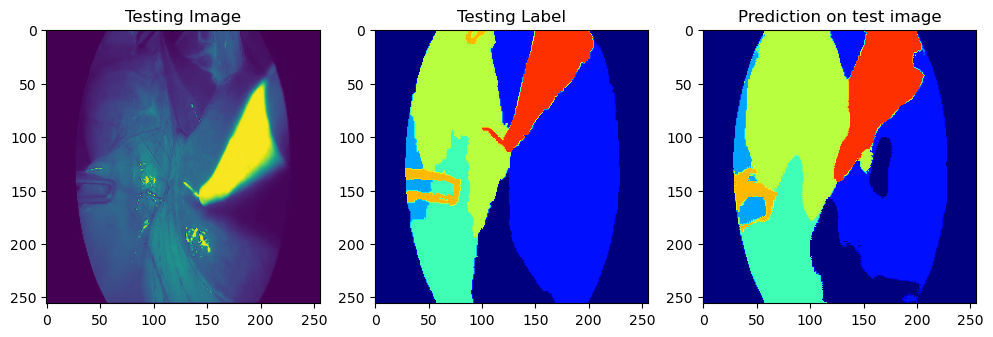

1/1 [==============================] - 0s 11ms/step


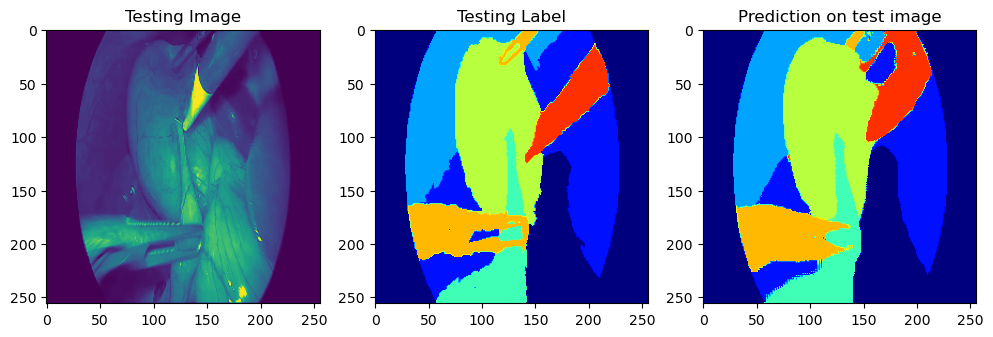

1/1 [==============================] - 0s 10ms/step


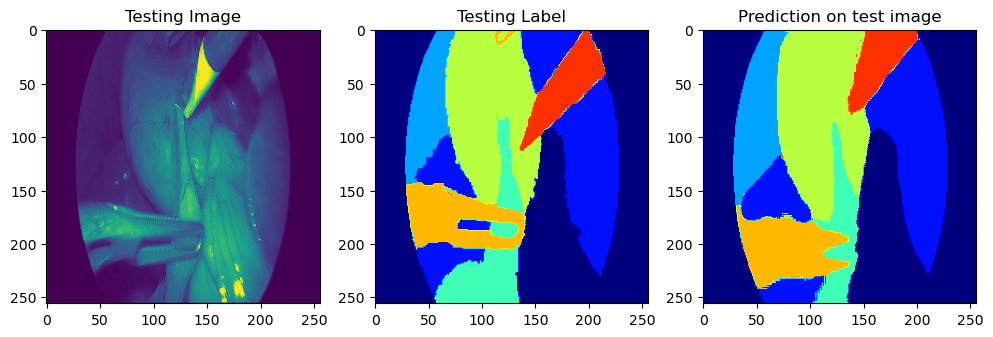

1/1 [==============================] - 0s 10ms/step


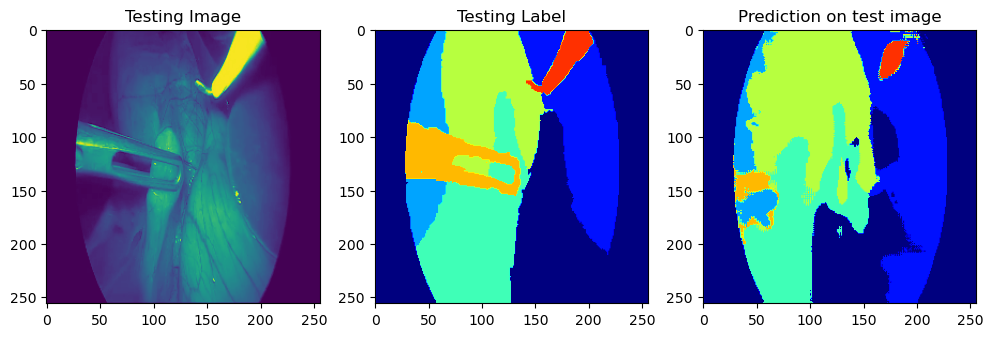

1/1 [==============================] - 0s 10ms/step


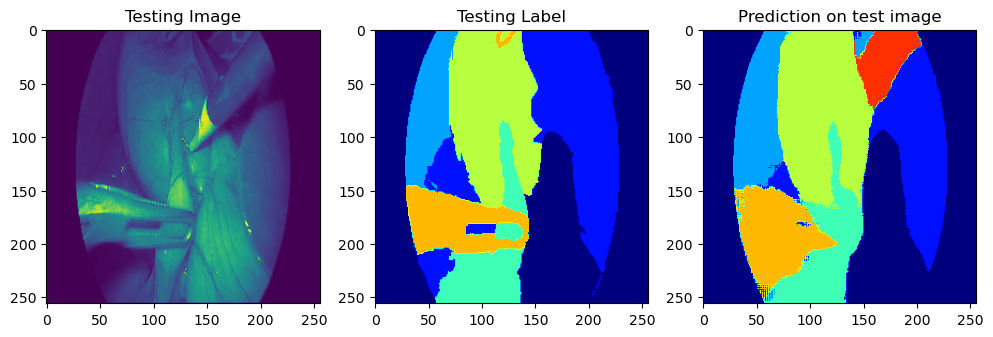

1/1 [==============================] - 0s 10ms/step


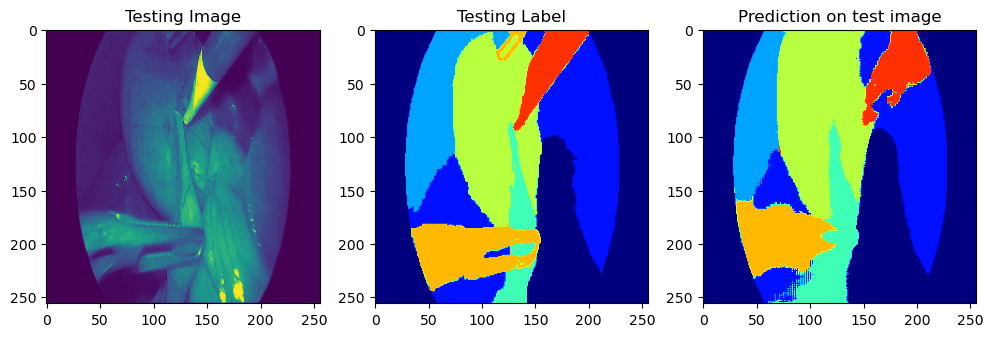

In [111]:
for i in range(len(X_test)):
  test_img_number = i
  test_img = X_test[test_img_number]
  ground_truth=y_test[test_img_number]
  test_img_norm=test_img#[:,:,0][:,:,None]
  test_img_input=np.expand_dims(test_img_norm, 0)
  prediction = (model.predict(test_img_input))
  predicted_img=np.argmax(prediction, axis=3)[0,:,:]


  plt.figure(figsize=(12, 8))
  plt.subplot(231)
  plt.title('Testing Image')
  plt.imshow(test_img)
  plt.subplot(232)
  plt.title('Testing Label')
  plt.imshow(ground_truth[:,:,0], cmap='jet')
  plt.subplot(233)
  plt.title('Prediction on test image')
  plt.imshow(predicted_img, cmap='jet')
  plt.show()

In [112]:
param, acc = model.evaluate(X_test, y_test_cat)

1/1 [==============================] - 0s 341ms/step - loss: 0.5703 - accuracy: 0.8076


In [113]:
print("Accuracy is = ", (acc * 100.0), "%")

Accuracy is =  80.7647705078125 %


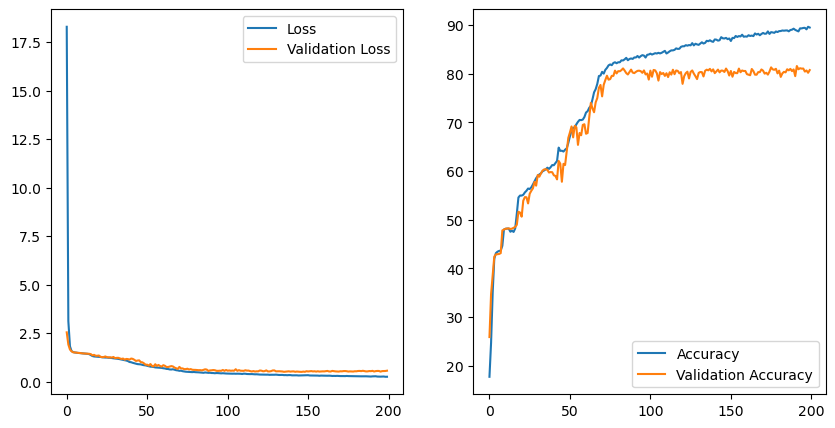

In [114]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(history.history['loss'], '-', label = 'Loss')
ax1.plot(history.history['val_loss'], '-', label = 'Validation Loss')
ax1.legend()

ax2.plot(100*np.array(history.history['accuracy']), '-', 
         label = 'Accuracy')
ax2.plot(100*np.array(history.history['val_accuracy']), '-',
         label = 'Validation Accuracy')
ax2.legend()